In [3]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import copy
import time 
import matplotlib.pyplot as plt
import pickle # Lokales Speichern von Objekten
import keyboard

from GNM_Toolbox.tools.tools import *
from GNM_Toolbox.gnm import *
from GNM_Toolbox.data.dataloader import *

dataset = load_dataset('Citeseer')

Found dataset on harddrive.


# Some Helping Functions

In [4]:
# Gegeben sei eine target_list (a_0, a_1, a_2, ...)
# und eine out_list ((b_0, x), (b_1, x), (b_2, x), (b_3, x), ...)
# out_list darf tupel beliebiger Länge haben. 
# Gesucht wird eine Liste l von Indizes, sodass für i < len(target_list): abs(target_list[i] - out_list[l[i]][0]) minimal ist
def find_each_nearest(target_list, out_list, idx = 0):
    # Each list is expected to be sorted
    i, j = 0, 0
    result = list()
    while True:
        diff_0 = abs(target_list[i] - out_list[j][idx])
        diff_1 = abs(target_list[i] - out_list[j+1][idx])
        
        if diff_0 >= diff_1:
            j += 1
        elif diff_0 < diff_1:
            result.append(j)
            i += 1
        if i >= len(target_list):
            return result
        if j+1 >= len(out_list):
            while i < len(target_list):
                result.append(j)
                i += 1
            return result
            
def get_best_values_indices(targets, lambdas):
    lambdas.sort(key = lambda x: x[0])
    return find_each_nearest(targets, lambdas)

def h(x):
    a0, a1, a2, a3 = 13, 4, 15, 15
    return torch.exp(torch.sum(x, dim=1)/a0 - a1) - ((torch.sum(x, dim=1) - a2 ) / a3)
    
def pi(X, y):
    y0 = F.one_hot(y, 6)
    # y should be one-hot encoded
    a0, a1, a2 = -torch.log(torch.tensor(20.)), 1, torch.tensor([[5, 0.5, 0.2, 1, 0.5, 2]]).view((6, 1))
    return torch.sigmoid(a0 + a1 * h(X).view((-1, 1)) + y0.type(torch.float) @ a2)

def create_mask_from_pi(data, pi):
    p = pi(data.x, data.y)
    mask = torch.tensor((np.random.binomial(size = p.shape[0], n = 1, p = p) == 1))        
    return mask.bool()

def split_known_mask_into_val_and_train_mask(known, ratio=0.8):
    val_mask = torch.zeros_like(known) == 1
    train_mask = torch.zeros_like(known) == 1
    for i in range(len(known)):
        if known[i] == True:
            if np.random.binomial(1, ratio) == 1:
                train_mask[i] = True
            else:
                val_mask[i] = True
    return val_mask, train_mask

def count_classes(y, mask):
    l = np.zeros((max(y)+1))
    for yy in y[mask]:
        l[yy] += 1
    return l

def calc_variance(y, mask):
    y_distribution = count_classes(y, mask)
    return np.var(y_distribution)
        
def insert_into_list(l, item, t):
    # l list, i item to insert, target
    def diff(a, b):
        return abs(a-b)
    N = len(l)
    if N == 0:
        l.insert(0, item)
        return
    d = diff(t, item[0])
    d_0 = diff(t, l[0][0])
    if d <= d_0:
        l.insert(0, item)
        return
    for i in range(N-1):
        d_0 = diff(t, l[i][0])
        d_1 = diff(t, l[i+1][0])
        if d_0 <= d and d <= d_1:
            l.insert(i+1, item)
            return
    l.append(item)

def disturb_y(y, probability): # y must have 2 classes
    y_dis = torch.zeros_like(y)
    for i in range(len(y)):
        if np.random.rand(1) < probability:
            y_dis[i] = 0 if np.random.rand(1) > 0.5 else 1
        else:
            y_dis[i] = y[i]
                
    return F.one_hot(y_dis, 2)

# root mean squared error
def RMSE(pi_est, pi_true):
    return torch.sqrt(F.mse_loss(pi_true, pi_est.view(pi_true.shape)))

# mean squared error
def MSE(pi_est, pi_true):
    return F.mse_loss(pi_true, pi_est)

# weighted mean squared error
def WMSE(pi_est, pi_true, weight):
    return torch.mean(weight * (pi_est - pi_true) ** 2)


# mean root error
def MRE(pi_est, pi_true):
    return torch.mean(torch.pow(abs(pi_est.view(pi_true.shape) - pi_true), 0.5))

# berechnet Gewichtungen für weighted mean square error
def calc_inverse_weights(pi_real):
    bins = torch.zeros(len(pi_real)).type(torch.float)
    pi = pi_real.detach().numpy()
    # Count 
    for p in pi_real:
        bins[int(p*100)] += 1
    bins = 1/bins
    bins[bins == (torch.tensor(1.)/0)] = 999999999
    return torch.sqrt(bins)

def eval_pi(pi_true, pi_est, diff=0.01):
    pi_diff = abs(pi_true.view(pi_est.shape)-pi_est)
    pi_binar = [(p < diff) for p in pi_diff]
    return sum(pi_binar)/(1. * pi_true.shape[0])

# Data Setup

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
data.num_classes = dataset.num_classes

# Create Masks

In [6]:
masks = list()
i = 0
while i < 4000:
    mask = create_mask_from_pi(data, pi)
    val_mask, train_mask = split_known_mask_into_val_and_train_mask(mask)
    l = calc_variance(data.y, train_mask)
    if l > 0:
        masks.append([train_mask, val_mask, l])
        i += 1
        print(i, end='\r')
masks.sort(key=lambda x: x[2])

(60.299777777777784, 24.229640376822008)

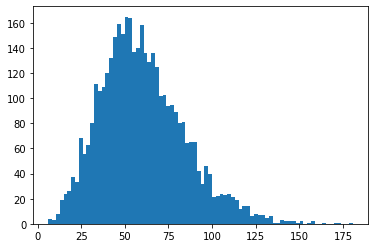

In [9]:
lambdas = list()
for mask in masks:
    lambdas.append(mask[2])
plt.hist(lambdas, 80);
np.mean(lambdas), np.std(lambdas)

In [14]:
targets = np.linspace(10, 120, 200) # choose masks depending on lambdas
idxs = find_each_nearest(targets, masks, idx=2)
idxs = list(dict.fromkeys(idxs)) # remove duplicates
print(len(idxs))
choosen_masks = [masks[i] for i in idxs]
#pickle_write('algorithm-analysis-citeseer-6-masks.pkl', choosen_masks)

200


In [15]:
masks = pickle_read('algorithm-analysis-citeseer-6-masks.pkl')

# Evaluate Models

In [20]:
# Eval 
NB_masks = 200
choosen_masks = masks[::-1]
IT_PER_MASK = 2
M = len(choosen_masks)
all_models = None
if False:
    all_models = pickle_read('algorithm-analysis-citeseer-6.pkl')
else:
    all_models = {'sm': list(), 'gnm': list(), 'gnmi': list()}
    
sm_models = all_models['sm']
gnm_models = all_models['gnm']
gnmi_models = all_models['gnmi']

In [21]:
# Iteriere über Masken
t_0 = time.time()
for j, mask_tupel in enumerate(choosen_masks):
    train_mask, val_mask, l = mask_tupel

    # Trainiere jeweils N Modelle
    for k in range(IT_PER_MASK):
        print_status(j * IT_PER_MASK + k, M * IT_PER_MASK, t_0)
        
        try:
            t = time.time()
            _, _, acc_list = train_net_with_gnm(data, train_mask, val_mask)
            gnm_models.append([l, acc_list[-1], time.time()-t])
        except Exception as e: 
            print(e)
            
        try:
            t = time.time()
            _, _, acc_gnmi = train_net_with_gnm_improved(data, train_mask, val_mask)
            gnmi_models.append([l, acc_gnmi, time.time()-t])
        except Exception as e: 
            print(e)
        
        try:
            _, _, acc_sm, _ = train_one_net(data, train_mask, val_mask)
            sm_models.append([l, acc_sm])
        except Exception as e: 
            print(e)
        
        
        
        all_models = {'gnm': gnm_models, 'gnmi': gnmi_models, 'sm': sm_models}
        pickle_write('algorithm-analysis-citeseer-6.pkl', all_models)